<a href="https://colab.research.google.com/github/vaidande/Car-Damage-Detection-Detectron2/blob/main/Car_Damage_Detection_Detectron2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!nvidia-smi

Fri Apr 30 13:31:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     7W /  75W |      0MiB /  7611MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

     |████████████████████████████████| 276kB 5.2MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.1-cp37-cp37m-linux_x86_64.whl size=44074 sha256=5e10bab47a60acb6256fccf8a09036d624a55060b3493bc6d4a53274971723d4
  Stored in directory: /root/.cache/pip/wheels/ad/56/bc/1522f864feb2a358ea6f1a92b4798d69ac783a28e80567a18b
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.8.1+cu101 True


In [4]:
import torch
assert torch.__version__.startswith("1.8")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.8/index.html
     |████████████████████████████████| 6.2MB 835kB/s 
     |████████████████████████████████| 51kB 5.8MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=af83b9c1dcefe84e1e87d4513543ca815cb79deaecfe0383d739a3526df1412c
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
Successfully built fvcore


In [5]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import matplotlib.pyplot as plt
import numpy as np
import cv2, os, json, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [6]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("train", {}, "/content/gdrive/MyDrive/car_damage/train/COCO_mul_train_annos.json", "/content/gdrive/MyDrive/car_damage/train")
register_coco_instances("valid", {}, "/content/gdrive/MyDrive/car_damage/val/COCO_mul_val_annos.json", "/content/gdrive/MyDrive/car_damage/val")

In [7]:
train_metadata = MetadataCatalog.get("train")
dataset_dicts = DatasetCatalog.get("train")

[04/30 13:32:20 d2.data.datasets.coco]: Loaded 59 images in COCO format from /content/gdrive/MyDrive/car_damage/train/COCO_mul_train_annos.json


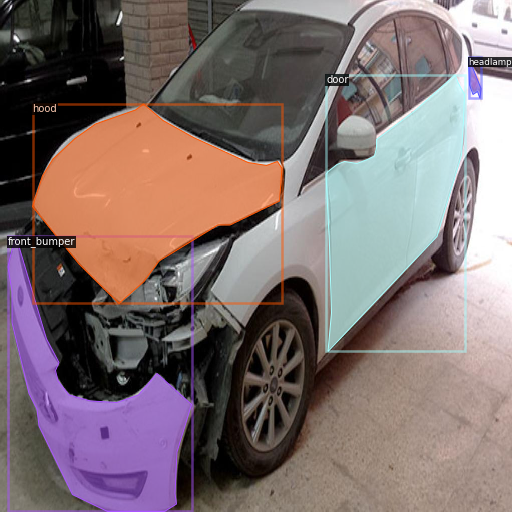

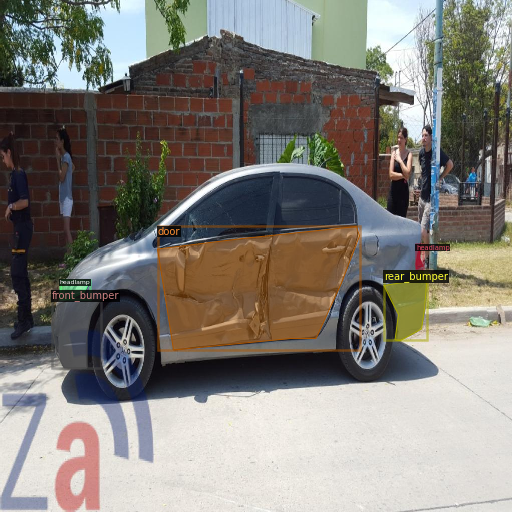

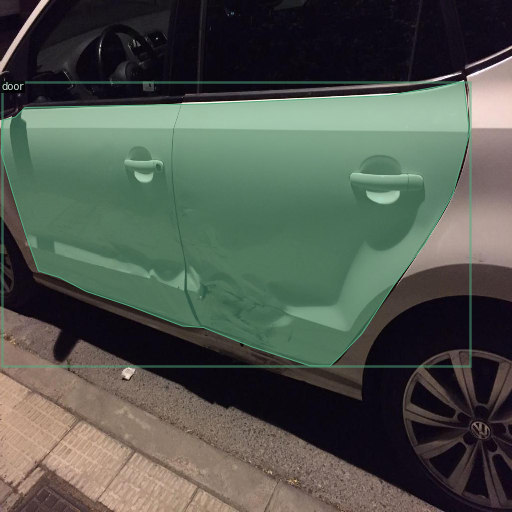

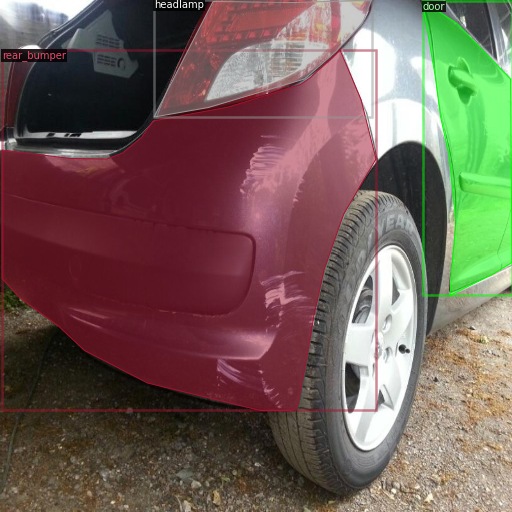

In [8]:
import random

for d in random.sample(dataset_dicts, 4):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(d)
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [9]:
cd /content

/content


In [10]:
!git clone https://github.com/facebookresearch/detectron2 detectron2_repo

Cloning into 'detectron2_repo'...
remote: Enumerating objects: 12005, done.
remote: Counting objects: 100% (746/746), done.
remote: Compressing objects: 100% (353/353), done.
remote: Total 12005 (delta 425), reused 672 (delta 390), pack-reused 11259
Receiving objects: 100% (12005/12005), 4.90 MiB | 18.05 MiB/s, done.
Resolving deltas: 100% (8644/8644), done.


In [12]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

cfg = get_cfg()
cfg.merge_from_file("./detectron2_repo/configs/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("train")
cfg.DATASETS.TEST = ("valid")   # no metrics implemented for this dataset
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = "detectron2://COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl"  # initialize from model zoo
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 4000    # 300 iterations seems good enough, but you can certainly train longer
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128   # faster, and good enough for this toy dataset
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5  # 3 classes (Person, Helmet, Car)

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()

[04/30 13:35:34 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:10, 17.1MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (6, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (6,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (20, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (20,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to

[04/30 13:35:46 d2.engine.train_loop]: Starting training from iteration 0
[04/30 13:35:58 d2.utils.events]:  eta: 0:30:02  iter: 19  total_loss: 3.385  loss_cls: 1.932  loss_box_reg: 0.5627  loss_mask: 0.69  loss_rpn_cls: 0.1123  loss_rpn_loc: 0.02184  time: 0.5631  data_time: 0.1284  lr: 4.9952e-05  max_mem: 1860M
[04/30 13:36:08 d2.utils.events]:  eta: 0:31:34  iter: 39  total_loss: 2.68  loss_cls: 1.057  loss_box_reg: 0.7719  loss_mask: 0.6816  loss_rpn_cls: 0.04483  loss_rpn_loc: 0.02174  time: 0.5156  data_time: 0.0052  lr: 9.9902e-05  max_mem: 1860M
[04/30 13:36:17 d2.utils.events]:  eta: 0:31:24  iter: 59  total_loss: 2.458  loss_cls: 0.8266  loss_box_reg: 0.8866  loss_mask: 0.6596  loss_rpn_cls: 0.05303  loss_rpn_loc: 0.02349  time: 0.5010  data_time: 0.0057  lr: 0.00014985  max_mem: 1860M
[04/30 13:36:27 d2.utils.events]:  eta: 0:31:35  iter: 79  total_loss: 2.31  loss_cls: 0.7557  loss_box_reg: 0.8233  loss_mask: 0.6264  loss_rpn_cls: 0.02857  loss_rpn_loc: 0.02273  time: 0.5

KeyError: ignored

In [25]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "/content/gdrive/MyDrive/car_damage/model/output/model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg.DATASETS.TEST = ("valid")
predictor = DefaultPredictor(cfg)

[04/30 14:42:50 d2.data.datasets.coco]: Loaded 11 images in COCO format from /content/gdrive/MyDrive/car_damage/val/COCO_mul_val_annos.json


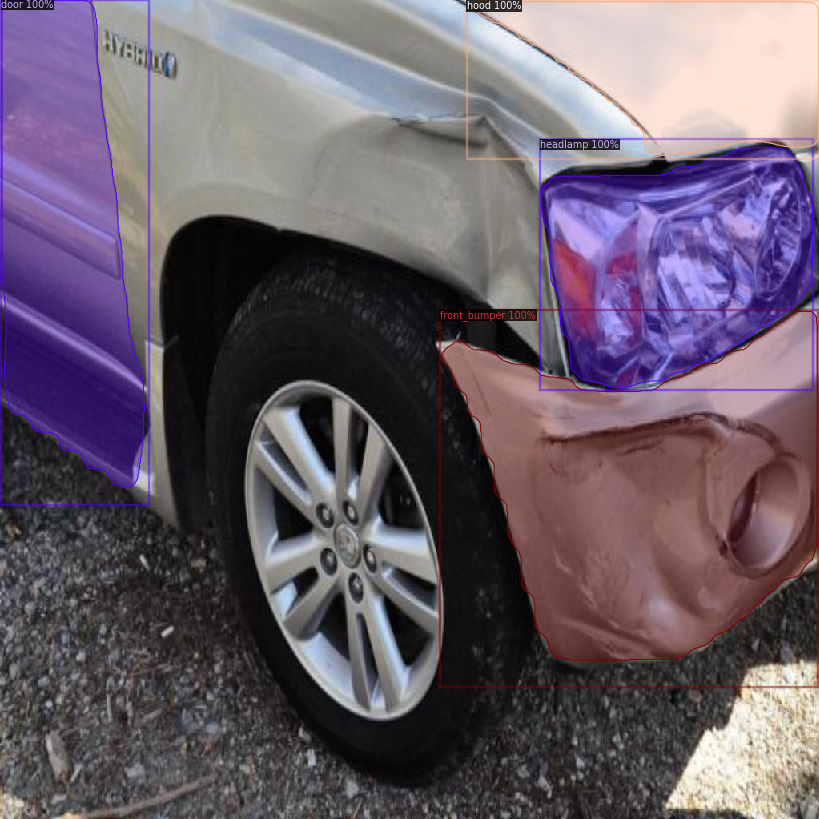

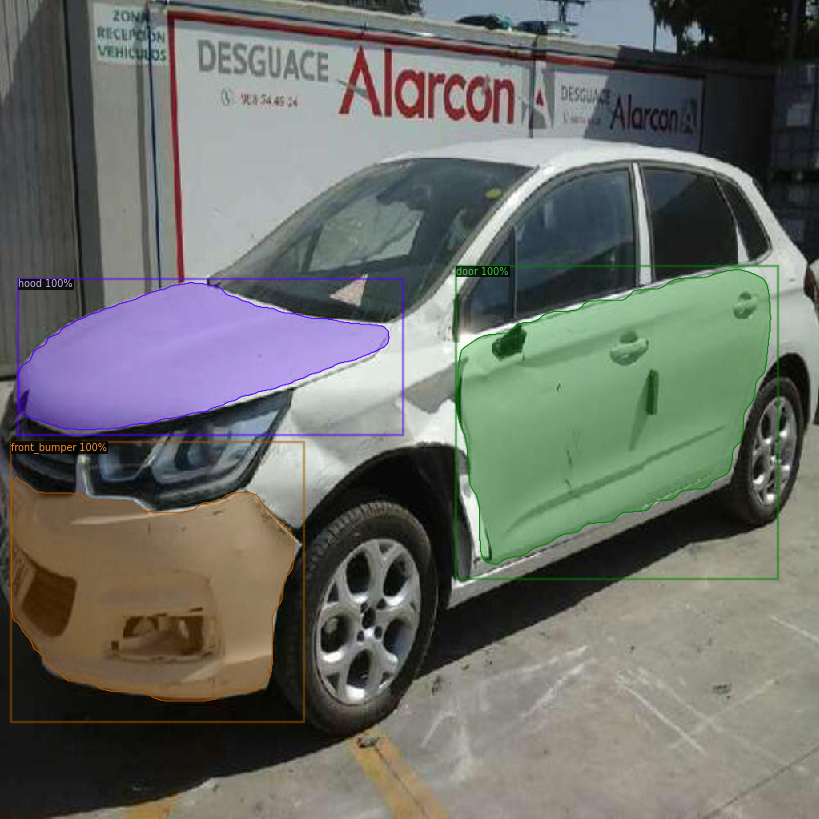

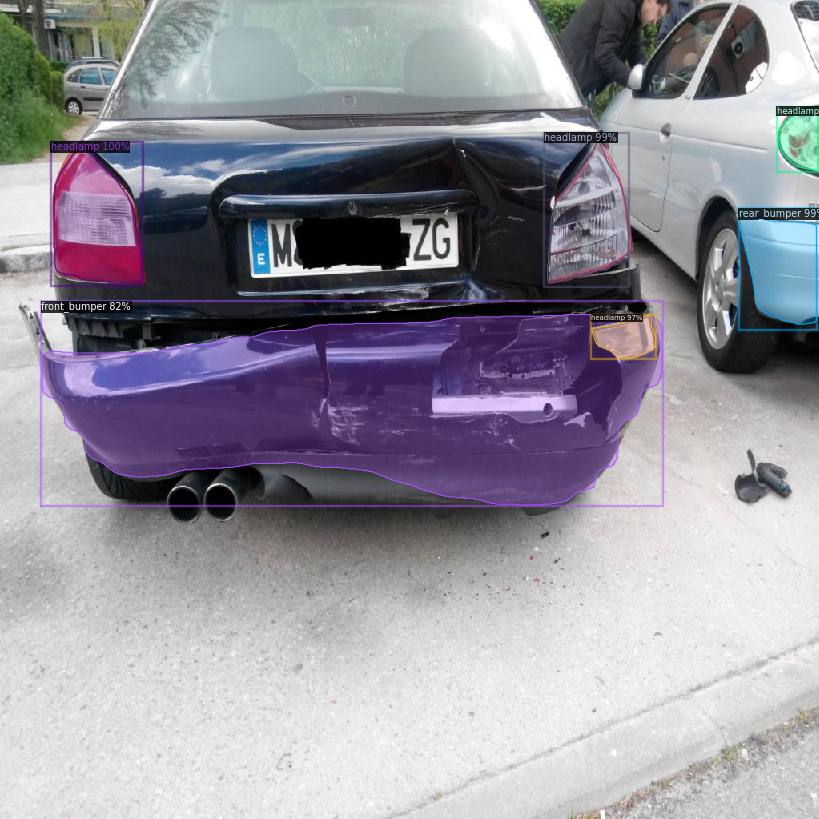

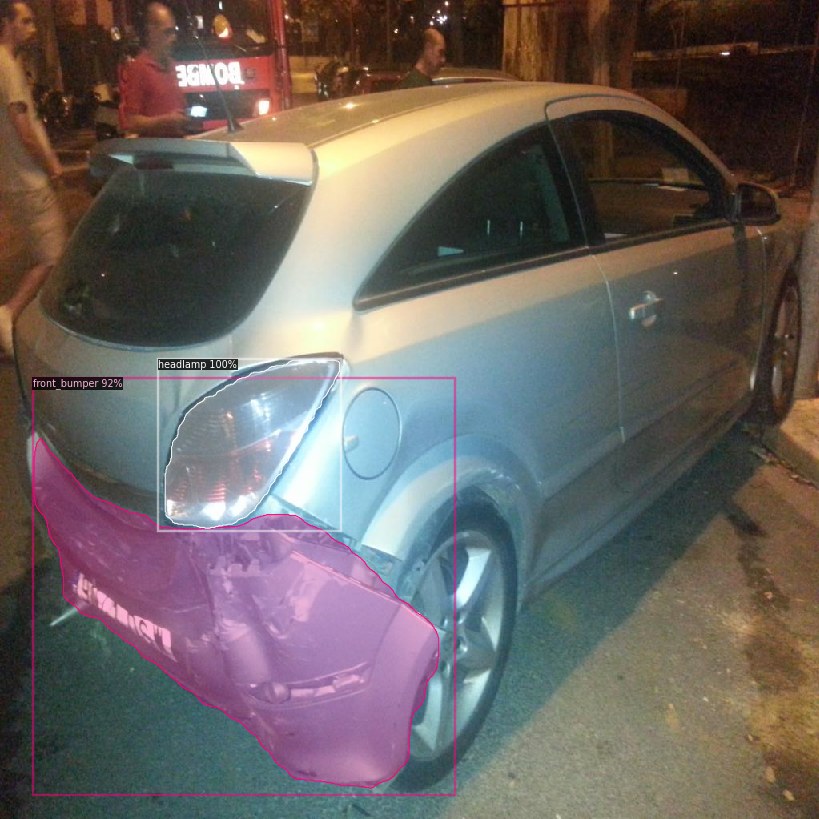

In [26]:
from detectron2.utils.visualizer import ColorMode

dataset_dicts = DatasetCatalog.get("valid")
for d in random.sample(dataset_dicts, 4):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=train_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    cv2_imshow(v.get_image()[:, :, ::-1])